In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os, glob, random, time
import tensorflow as tf
import matplotlib.image as mpimg
import pickle as pk
import matplotlib.pyplot as plt
import keras
import numpy as np
import pandas as pd

from keras.layers import Dense, ZeroPadding2D, Activation
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Input, Lambda, Flatten, concatenate
from keras.layers import BatchNormalization
from keras.models import Model
from keras import backend as K
from keras.preprocessing.image import load_img, img_to_array

from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.svm import SVC

In [ ]:
random.seed(42)

train_split = 0.7

same_pet = 1
different_pet = 0

In [ ]:
local_path = '/content'
remote_path = '/content/drive/MyDrive/Petfinding'

cat_pet_type_id = 1
dog_pet_type_id = 2
pet_type_ids = [cat_pet_type_id, dog_pet_type_id]

In [ ]:
cat_images_path = local_path + '/CatFace/Images'
dog_images_path = local_path + '/DogFace/Images'

In [ ]:
!rm -R /content/CatFace
!mkdir /content/CatFace
!cp /content/drive/MyDrive/Petfinding/FaceVerification/CatFace.zip /content/CatFace.zip
!unzip -q /content/CatFace.zip -d /content/CatFace

!rm -R /content/DogFace
!mkdir /content/DogFace
!cp /content/drive/MyDrive/Petfinding/FaceVerification/DogFace.zip /content/DogFace.zip
!unzip -q /content/DogFace.zip -d /content/DogFace

rm: cannot remove '/content/CatFace': No such file or directory
rm: cannot remove '/content/DogFace': No such file or directory


In [ ]:
# Finds all JPG files in the folders
def image_paths_to_image_files(image_paths):
    image_files = []
    for image_path in image_paths:
        image_files += glob.glob(image_path + '/*.jpg')
    return image_files


# Helper function for when grouping all images by pet_id
def image_file_to_list(df):
    assert len(np.unique(df['pet_type_id'])) == 1 
    image_files = list(df['image_file'].values)
    image_files_len = len(image_files)
    return pd.Series([df.iloc[0]['pet_type_id'], image_files_len, image_files], index=['pet_type_id', 'image_files_len', 'image_files'])


# Group dataframe by pet_id
def groupby_pet_id(df):
  sample_df = df.groupby('pet_id').apply(image_file_to_list).reset_index()
  return sample_df


In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input


def create_face_features_for_image_file(efficient_net_model, image_file):
    image_bytes = image.load_img(image_file, target_size=(260, 260))
    image_bytes = image.img_to_array(image_bytes)
    image_bytes = np.expand_dims(image_bytes, axis=0)
    image_bytes = preprocess_input(image_bytes)
    return efficient_net_model.predict(image_bytes)


def create_face_features_for_image_files(efficient_net_model, image_files):
    image_files_to_face_features = {}
    for image_file in image_files:
      image_files_to_face_features[image_file] = create_face_features_for_image_file(efficient_net_model, image_file)
    return image_files_to_face_features


def create_face_features_pair(face_features_1, face_features_2):
    return np.concatenate((face_features_1, face_features_2), axis=1)


def create_face_features_pairs(image_file_pairs, image_file_to_face_features):
    face_features_pairs = []
    for image_file_pair in image_file_pairs:
        face_features_1 = image_file_to_face_features[image_file_pair[0]]
        face_features_2 = image_file_to_face_features[image_file_pair[1]]
        face_features_pairs.append(create_face_features_pair(face_features_1, face_features_2))
    
    face_features_pairs = np.stack(face_features_pairs, axis=0)
    face_features_pairs = np.array(face_features_pairs).reshape(len(image_file_pairs), -1)
    return face_features_pairs

    

In [ ]:
# Load image paths into DataFrame and group them by their pet ID
df = []
for images_path, pet_type_id in [(cat_images_path, cat_pet_type_id), (dog_images_path, dog_pet_type_id)]:
    image_files = glob.glob(images_path + '/*.jpg')
    print(f'Pet type ID {pet_type_id} images = {len(image_files)}')

    df_temp = pd.DataFrame(data={'image_file': image_files})
    df_temp['pet_id'] = df_temp['image_file'].apply(lambda x: x.split('/')[-1].split('-')[0])
    df_temp['pet_type_id'] = pet_type_id
    
    df.append(df_temp)

df = pd.concat(df, ignore_index=True)

df = groupby_pet_id(df)
print(f'Total pets = {len(df)}')

# Split the images into train and test by the index of 
df_indexes = df.index.to_numpy()
np.random.shuffle(df_indexes)

train_df_indexes, test_df_indexes = np.split(df_indexes, [int(train_split * len(df_indexes))]) 
train_df = df.iloc[train_df_indexes].reset_index(drop=True)
test_df = df.iloc[test_df_indexes].reset_index(drop=True)

print(f'Total train pets = {len(train_df)}, total test pets = {len(test_df)}')

Pet type ID 1 images = 14067
Pet type ID 2 images = 8363
Total pets = 4433
Total train pets = 3103, total test pets = 1330


In [ ]:
def get_same_pet_pair(df, pet_type_id):
    pet = df[df['pet_type_id'] == pet_type_id].sample().iloc[0]
    return sorted(list(np.random.choice(pet['image_files'], 2)))


def get_different_pet_pair(df, pet_type_ids):
    pet_1 = df[df['pet_type_id'] == pet_type_ids[0]].sample().iloc[0]
    while True:
        pet_2 = df[df['pet_type_id'] == pet_type_ids[1]].sample().iloc[0]
        if pet_1['pet_id'] != pet_2['pet_id']:
            break
            
    return sorted([np.random.choice(pet_1['image_files'], 1)[0], np.random.choice(pet_2['image_files'], 1)[0]])
    


def create_image_pairs(df, num_pairs, same_pair_split):
    assert same_pair_split > 0 and same_pair_split < 1

    x = []
    y = []

    for i in range(num_pairs):
        if random.random() < same_pair_split:
            # Get same pair
            same_pet_type_id = np.random.choice(pet_type_ids)
            while True:
                same_pet_pair = get_same_pet_pair(df, same_pet_type_id)
                if same_pet_pair not in x:
                    break

            x.append(same_pet_pair)
            y.append(same_pet)
        else:
            # Get different pair
            different_pet_type_ids = [np.random.choice(pet_type_ids), np.random.choice(pet_type_ids)]
            while True:
                different_pet_pair = get_different_pet_pair(df, different_pet_type_ids)
                if different_pet_pair not in x:
                    break

            x.append(different_pet_pair)
            y.append(different_pet)

    return x, y
        



In [ ]:
x_train, y_train = create_image_pairs(train_df, 15000, 0.5)
x_test, y_test = create_image_pairs(test_df, 5000, 0.5)

In [ ]:
len(x_train), len(y_train), (np.array(y_train) == 0).sum() * 2, len(x_test), len(y_test), (np.array(y_test) == 0).sum() * 2

(15000, 15000, 15020, 5000, 5000, 5118)

In [ ]:
from tensorflow.keras.applications.efficientnet import EfficientNetB2
from tensorflow.keras.layers import MaxPooling2D, GlobalMaxPool2D, GlobalAveragePooling2D, AveragePooling2D

base_efficient_net_model = EfficientNetB2(weights='imagenet', pooling = 'max')
base_efficient_net_model = Model(base_efficient_net_model.input, base_efficient_net_model.layers[-4].output)
base_efficient_net_model.trainable = False
x = base_efficient_net_model.output
x = AveragePooling2D(pool_size=(2, 2), strides= (1, 1), padding='valid')(x)
x = GlobalAveragePooling2D()(x)
norm_layer = Lambda(lambda x: K.l2_normalize(x, axis=1), name='norm_layer')(x)
efficient_net_model = Model(inputs=base_efficient_net_model.input, outputs=norm_layer)

37445632/37432240 [==============================] - 0s 0us/step


In [ ]:
image_files = image_paths_to_image_files([cat_images_path, dog_images_path])
image_files_to_face_features = create_face_features_for_image_files(efficient_net_model, image_files)

In [ ]:
x_train_face_features_pairs = create_face_features_pairs(x_train, image_files_to_face_features)
x_test_face_features_pairs = create_face_features_pairs(x_test, image_files_to_face_features)

In [ ]:
x_train[1]

['/content/CatFace/Images/fb751ef23-1.jpg',
 '/content/CatFace/Images/fb751ef23-4.jpg']

In [ ]:
y_train[1]

1

In [ ]:
pca = PCA(0.90)
x_train_face_features_pairs = pca.fit_transform(x_train_face_features_pairs)
x_test_face_features_pairs = pca.transform(x_test_face_features_pairs)

In [ ]:
x_train_face_features_pairs.shape

(15000, 591)

0 = different pet, 1 = same pet

In [ ]:
svc = SVC(probability=True)
pred = svc.fit(x_train_face_features_pairs, y_train)

In [ ]:
efficient_net_model.save(remote_path + '/Models/EfficientNet')
pk.dump(pca, open(remote_path + '/Models/PCA.pkl','wb'))
pk.dump(svc, open(remote_path + '/Models/SVC.pkl','wb'))

In [ ]:
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay, DetCurveDisplay, PrecisionRecallDisplay

In [ ]:
pred_test = svc.predict_proba(x_test_face_features_pairs)
pred_y_test = np.round(pred_test[:,1])

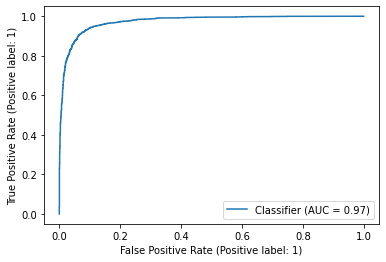

In [ ]:
roc_curve_display_test = RocCurveDisplay.from_predictions(y_test, pred_test[:,1])

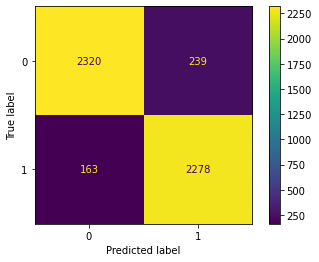

In [ ]:
confusion_matrix_display_test = ConfusionMatrixDisplay.from_predictions(y_test, pred_y_test)

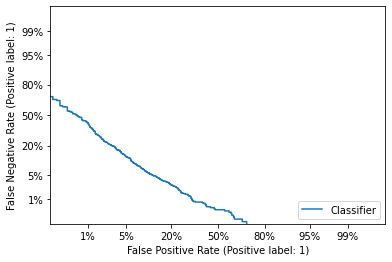

In [ ]:
det_curve_display_test = DetCurveDisplay.from_predictions(y_test, pred_test[:,1])

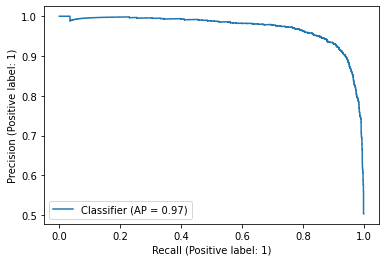

In [ ]:
precision_recall_display_test = PrecisionRecallDisplay.from_predictions(y_test, pred_test[:,1])

In [ ]:
pred_train = svc.predict_proba(x_train_face_features_pairs)
pred_y_train = np.round(pred_train[:,1])

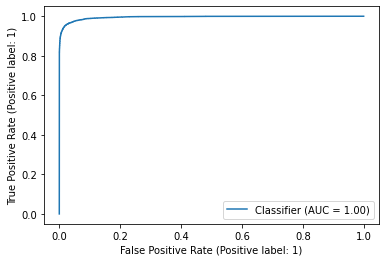

In [ ]:
roc_curve_display_train = RocCurveDisplay.from_predictions(y_train, pred_train[:,1])

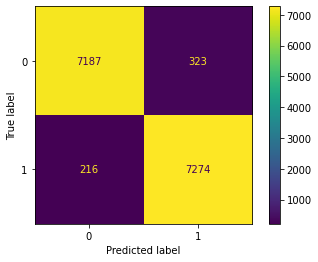

In [ ]:
confusion_matrix_display_train = ConfusionMatrixDisplay.from_predictions(y_train, pred_y_train)

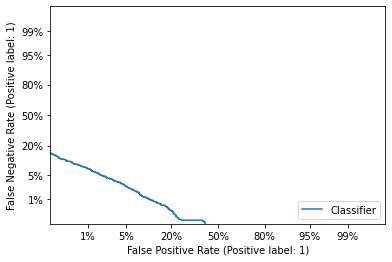

In [ ]:
det_curve_display_train = DetCurveDisplay.from_predictions(y_train, pred_train[:,1])

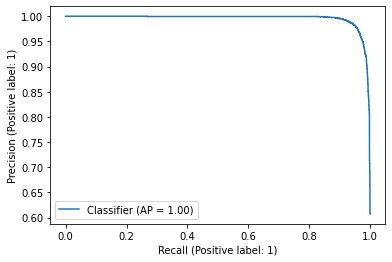

In [ ]:
precision_recall_display_train = PrecisionRecallDisplay.from_predictions(y_train, pred_train[:,1])